# Grid scan and time series at the beamline

## Load the name space of the beamtime

In [1]:
# load the beamtime name space
%run -i 999-load2.py

/Users/sst/anaconda3/envs/test_xpdstack/lib/python3.8/site-packages/databroker/v1.py:1602: UserWarning: Failed to load config. Falling back to v0.Exception was: Unable to handle metadatastore.module 'databroker.headersource.sqlite'
  warnings.warn(


No config file could be found in the following locations:
/Users/sst/.config/acq
/Users/sst/anaconda3/envs/test_xpdstack/etc/acq
/etc/acq
Loading from packaged simulation configuration
INFO: Initializing the XPD data acquisition environment ...
INFO: area detector has been configured to new acquisition time (time per frame)  = 0.1s
INFO: Reload beamtime objects:

ScanPlans:
0: ct_5
1: ct_0.1
2: ct_1
3: ct_10
4: ct_30
5: ct_60
6: Tramp_5_300_310_3

Samples:
0: Ni

{'Verification time': '2021-03-15 12:09:00', 'Verified by': 'st'}



Is this configuration correct? y/n:  y
Please input your initials:  st


INFO: beamtime object has been linked

INFO: Initialized glbl, bt, xrun.
INFO: Publish data to localhost port 5567 with prefix 'raw'.
INFO: Changed home to /Users/sst/acqsim/xpdUser
OK, ready to go.  To continue, follow the steps in the xpdAcqdocumentation at http://xpdacq.github.io/xpdacq


## Import the packages we need

In [2]:
import scanplans.planhelper as pth
import bluesky.plan_stubs as bps
import bluesky.plans as bp
import matplotlib.pyplot as plt

Here, I use some fake motors and a fake two dimensional detector.

In [3]:
# fake devices
from ophyd.sim import hw
HW = hw()
MOTORX = HW.motor1
MOTORY = HW.motor2
MOTORPHI = HW.motor3
DETECTOR = xpd_configuration['area_det']

## Set the exposure time

In [4]:
plan = pth.configure_area_det(DETECTOR, 0.1, 0.1)
xrun({}, plan)

INFO: requested exposure time = 0.1 - > computed exposure time= 0.1


()

## Grid scan

### A one dimensional scan

In [5]:
plan5 = pth.xpdacq_grid_scan([DETECTOR], MOTORX, -1, 1, 3)
uids5 = xrun(0, plan5)

INFO: closing shutter...
INFO: taking dark frame....
INFO: This scan will append calibration parameters recorded in /Users/sst/acqsim/xpdUser/config_base/xpdAcq_calib_info.poni
INFO: Current filter status
INFO: flt1 : In
INFO: flt2 : Out
INFO: flt3 : Out
INFO: flt4 : Out
dark frame complete, update dark dict
opening shutter...
INFO: This scan will append calibration parameters recorded in /Users/sst/acqsim/xpdUser/config_base/xpdAcq_calib_info.poni
INFO: Current filter status
INFO: flt1 : In
INFO: flt2 : Out
INFO: flt3 : Out
INFO: flt4 : Out


### Visualize the motor position and images in a scan

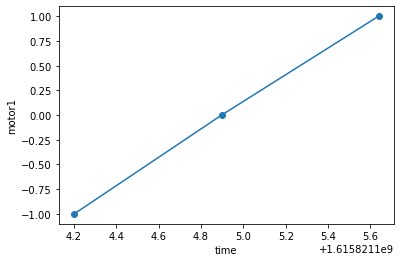

In [6]:
data = db[uids5[-1]].primary.read()
data["motor1"].plot(x="time", marker="o")
plt.show()

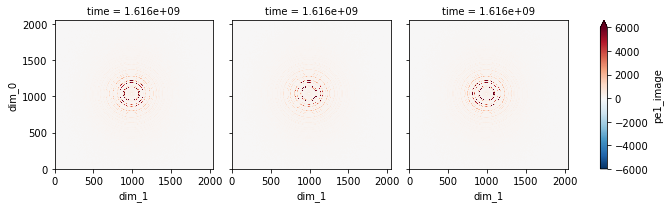

In [7]:
data["pe1_image"].plot(col="time", vmax=6e3)
plt.show()

### A two dimensional grid scan

We scan the sample by moving the MOTORX and MOTORY. The MOTORX and MOTORY will move from -1 to 1 and 3 points will be measured on the grid so there are 3 * 3 images in total.

In [8]:
plan0 = pth.xpdacq_grid_scan([DETECTOR], MOTORY, -1, 1, 3, MOTORX, -1, 1, 3)
uids0 = xrun(0, plan0)

INFO: This scan will append calibration parameters recorded in /Users/sst/acqsim/xpdUser/config_base/xpdAcq_calib_info.poni
INFO: Current filter status
INFO: flt1 : In
INFO: flt2 : Out
INFO: flt3 : Out
INFO: flt4 : Out


### Visualize the motor movement in a grid scan

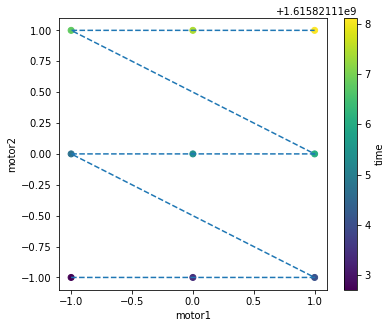

In [9]:
data = db[uids0[-1]].primary.read()
data.plot.scatter("motor1", "motor2", hue="time", size=5, aspect=1.2)
plt.plot(data["motor1"], data["motor2"], '--')
plt.show()

### A two dimensional snake scan

In [10]:
plan1 = pth.xpdacq_grid_scan([DETECTOR], MOTORY, -1, 1, 3, MOTORX, -1, 1, 3, snake_axes=True)
uids1 = xrun(0, plan1)

INFO: This scan will append calibration parameters recorded in /Users/sst/acqsim/xpdUser/config_base/xpdAcq_calib_info.poni
INFO: Current filter status
INFO: flt1 : In
INFO: flt2 : Out
INFO: flt3 : Out
INFO: flt4 : Out


### Visualize the motor movement in a snake scan

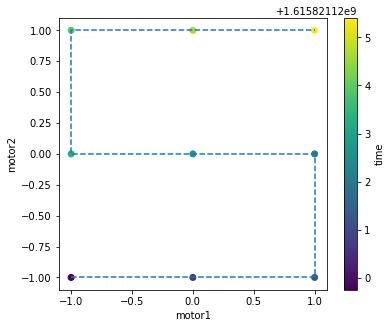

In [11]:
data = db[uids1[-1]].primary.read()
data.plot.scatter("motor1", "motor2", hue="time", size=5, aspect=1.2)
plt.plot(data["motor1"], data["motor2"], '--')
plt.show()

### A three dimension scan

In [12]:
plan2 = pth.xpdacq_grid_scan([DETECTOR], MOTORY, -1, 1, 3, MOTORX, -1, 1, 3, MOTORPHI, -30, 30, 3, snake_axes=[MOTORX])
uids2 = xrun(0, plan2)

INFO: This scan will append calibration parameters recorded in /Users/sst/acqsim/xpdUser/config_base/xpdAcq_calib_info.poni
INFO: Current filter status
INFO: flt1 : In
INFO: flt2 : Out
INFO: flt3 : Out
INFO: flt4 : Out


### Visualize the motor movement

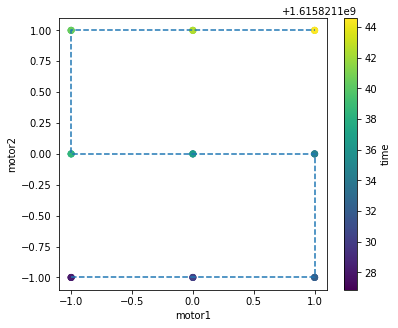

In [13]:
data = db[uids2[-1]].primary.read()
data.plot.scatter("motor1", "motor2", hue="time", size=5, aspect=1.2)
plt.plot(data["motor1"], data["motor2"], '--')
plt.show()

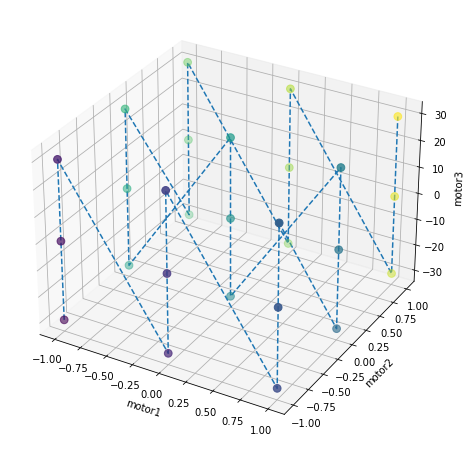

In [14]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.plot3D(data["motor1"], data["motor2"], data["motor3"], '--')
scatter = ax.scatter3D(data["motor1"], data["motor2"], data["motor3"], c=data["time"], s=60)
ax.set_xlabel('motor1')
ax.set_ylabel('motor2')
ax.set_zlabel('motor3')
plt.show()

## Time series

### Configure the velocity of a motor

In [5]:
plan = bps.mv(MOTORPHI.velocity, 10)
xrun({}, plan)

()

### A time series of one detector and one motor (use ramp plan)

In [5]:
# move the motor to 30, trigger and read dectector until it finishes
plan3 = pth.xpdacq_ramp_count([DETECTOR, MOTORPHI], MOTORPHI, 30)
uids3 = xrun(0, plan3)

INFO: closing shutter...
INFO: taking dark frame....
INFO: This scan will append calibration parameters recorded in /Users/sst/acqsim/xpdUser/config_base/xpdAcq_calib_info.poni
INFO: Current filter status
INFO: flt1 : In
INFO: flt2 : Out
INFO: flt3 : Out
INFO: flt4 : Out
dark frame complete, update dark dict
opening shutter...
INFO: This scan will append calibration parameters recorded in /Users/sst/acqsim/xpdUser/config_base/xpdAcq_calib_info.poni
INFO: Current filter status
INFO: flt1 : In
INFO: flt2 : Out
INFO: flt3 : Out
INFO: flt4 : Out


### Visualize the data

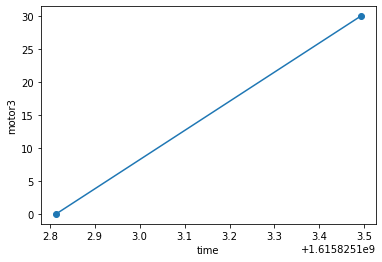

In [10]:
data = db[uids3[-1]].primary.read()
data["motor3"].plot(x="time", marker='o')
plt.show()

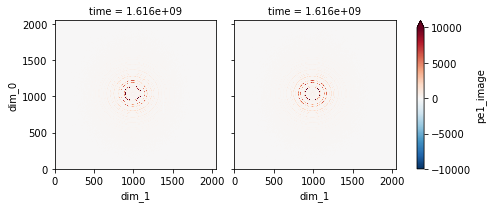

In [11]:
data["pe1_image"].plot(col="time", vmax=1e4)
plt.show()

### A time series (use set and count)

In [17]:
# move the motor to 30 and trigger and read dectector for 4 times in total and the period between the start of each trigger is 1 s.
plan4 = [bps.abs_set(MOTORPHI, 30, wait=False), pth.xpdacq_count([DETECTOR, MOTORPHI], 4, 1)]
uids4 = xrun(0, plan4)

INFO: This scan will append calibration parameters recorded in /Users/sst/acqsim/xpdUser/config_base/xpdAcq_calib_info.poni
INFO: Current filter status
INFO: flt1 : In
INFO: flt2 : Out
INFO: flt3 : Out
INFO: flt4 : Out


### Time series of the motor position

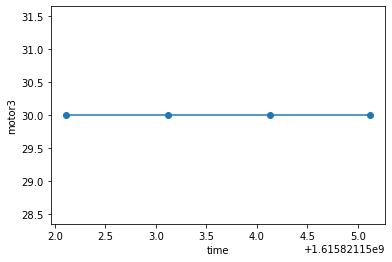

In [18]:
data = db[uids4[-1]].primary.read()
data["motor3"].plot(x="time", marker='o')

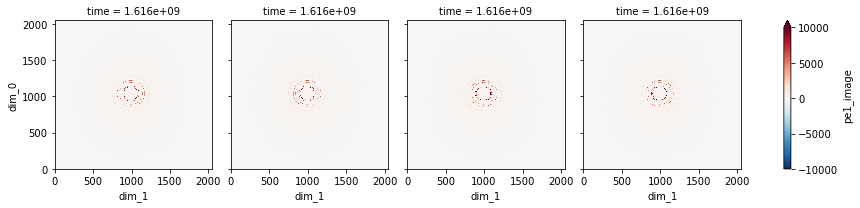

In [19]:
data["pe1_image"].plot(col="time", vmax=1e4)
plt.show()